# <center>**Partially Coded FOV Correct Analysis**<center>

**Libraries**

In [40]:
import numpy as np
from scipy.signal import correlate

import maskpattern as mp
import plot_module as plot
import balancing as bal
import stats

np.set_printoptions(precision=2, suppress=False)

In [64]:
import importlib
importlib.reload(stats)

<module 'stats' from '/home/starfloyd/PhD_Coding/MasksReconstructionTest/Img_ReconstructionMethods_2D/stats.py'>

## **2D URA/MURA Masks with PCFOV**

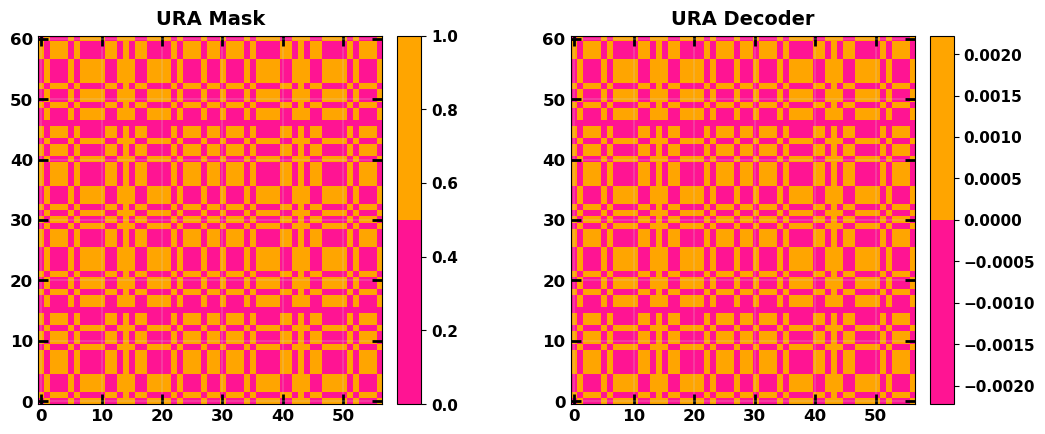

In [3]:
ura = mp.URAMaskPattern(4)
ura_pattern2D, ura_decoder2D = ura.basic_pattern, ura.basic_decoder

n, m = ura_pattern2D.shape
pad_n, pad_m = (n - 1)//2, (m - 1)//2

mask = np.pad(ura_pattern2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')
decoder = np.pad(ura_decoder2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')

plot.image_plot([mask, decoder],
                ["URA Mask", "URA Decoder"])

- Let's first simulate a sky image and then perform the cross-correlation to obtain the sky reconstruction

In [4]:
import collections.abc as c

def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, None | c.Sequence]:
    """Simulates the sky image given the sources flux."""

    sky_image = np.zeros(sky_image_shape)

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]

    # add sky background
    if sky_background_rate is not None:
        sky_background = np.random.poisson(sky_background_rate, sky_image_shape)
        sky_image += sky_background
    else:
        sky_background = None
    
    return sky_image, sky_background, sources_pos

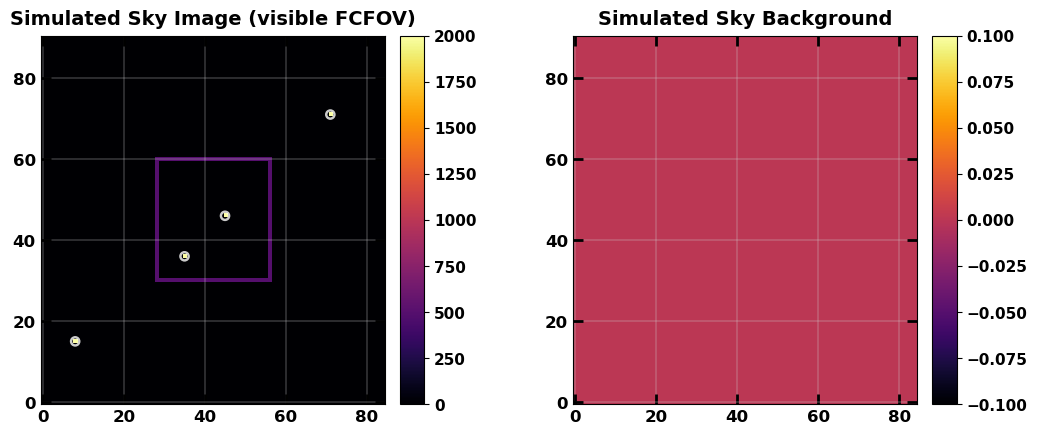

In [52]:
h, v = n - 1, m - 1
sky_shape = (n + 2*h, m + 2*v)

sources_flux = np.array([100, 100, 100, 100])*20
sources_pos = [(h - 15, v - 20), (n + 5, m + 6), (n + 15, m + 16), (h + n + 10, v + m + 14)]
sky_background_rate = 0

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

highlight_fcfov = True
if highlight_fcfov:
    base = np.ones((n - 2, m - 2))
    c_edge = np.pad(base, pad_width=[(1, 1), (1, 1)], constant_values=sources_flux.max()//4)

    sky_image_wfcfov = sky_image.copy()
    sky_image_wfcfov[h : -h, v : -v] += c_edge

    plot.image_plot([sky_image_wfcfov, sky_background],
                    ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

else:
    plot.image_plot([sky_image, sky_background],
                    ["Simulated Sky Image", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

cc_detector_image = sky image shape: True
pcfov_sky_reconstruction = sky image shape: True
fcfov_sky_reconstruction = basic pattern shape: True


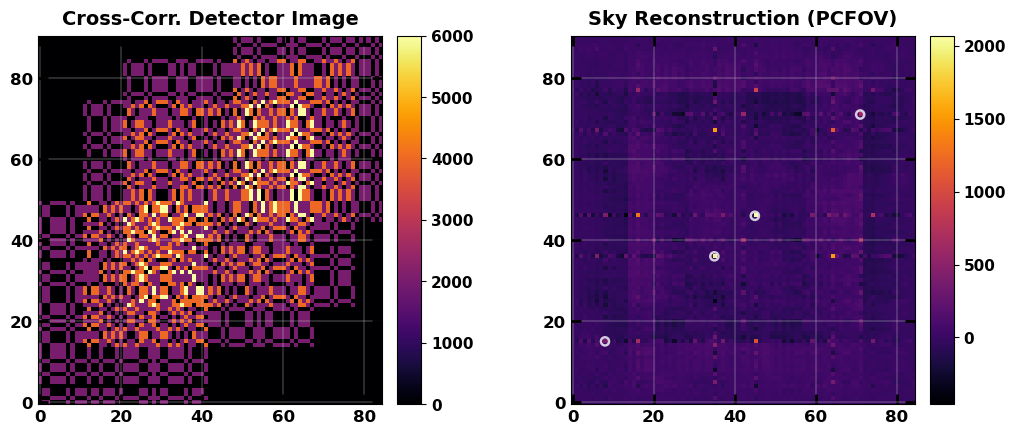

In [53]:
cc_detector_image = correlate(mask, sky_image, mode='full')[h : -h, v : -v]
fcfov_detector_image = cc_detector_image[h : -h, v : -v]                            ### detector area corresponding to FCFOV

pcfov_sky_reconstruction = correlate(decoder, fcfov_detector_image, mode='full')    ### here the FCFOV portion of the central detector image
fcfov_sky_reconstruction = pcfov_sky_reconstruction[h : -h, v : -v]

print(f"cc_detector_image = sky image shape: {np.all(cc_detector_image.shape == sky_shape)}\n"
      f"pcfov_sky_reconstruction = sky image shape: {np.all(pcfov_sky_reconstruction.shape == sky_shape)}\n"
      f"fcfov_sky_reconstruction = basic pattern shape: {np.all(fcfov_sky_reconstruction.shape == (n, m))}")

plot.image_plot([cc_detector_image, pcfov_sky_reconstruction],
                ["Cross-Corr. Detector Image", "Sky Reconstruction (PCFOV)"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[None, sources_pos])

- Due to the lower sensitivity when dealing with the sources in the PCFOV, the counts of the sources in this area (if any) are not well decoded

- If we look at the slices of the sky reconstruction:

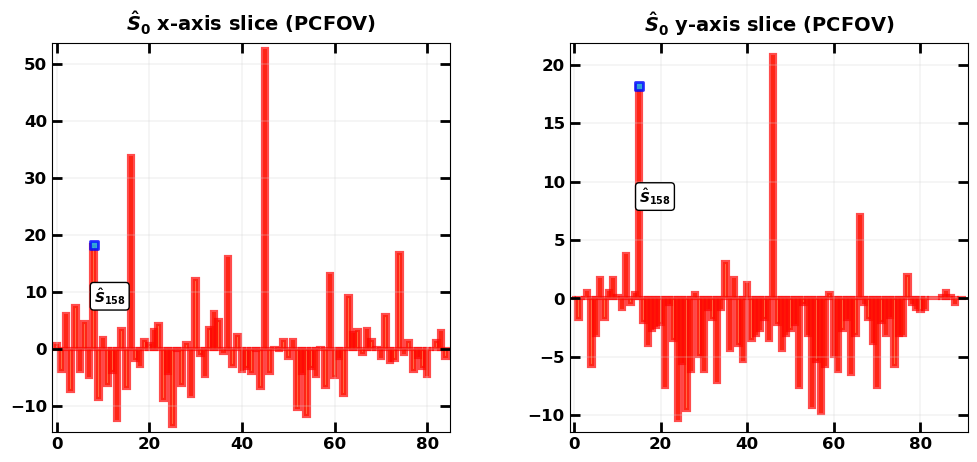

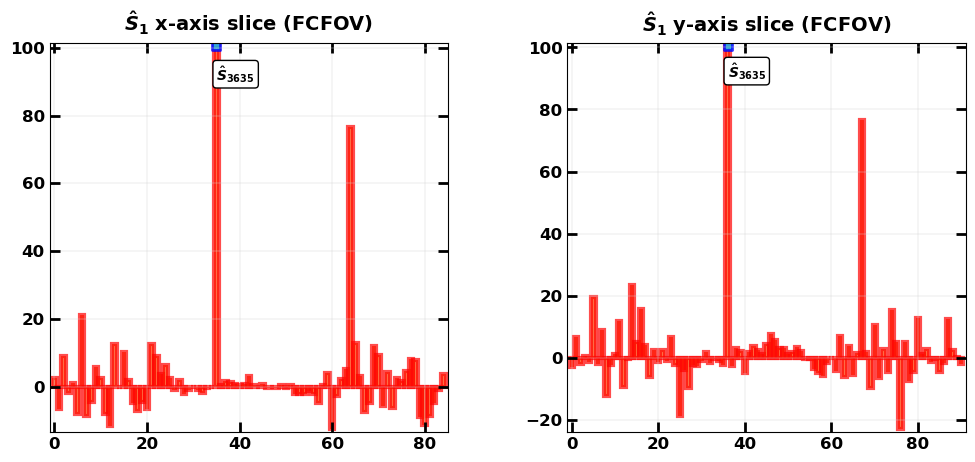

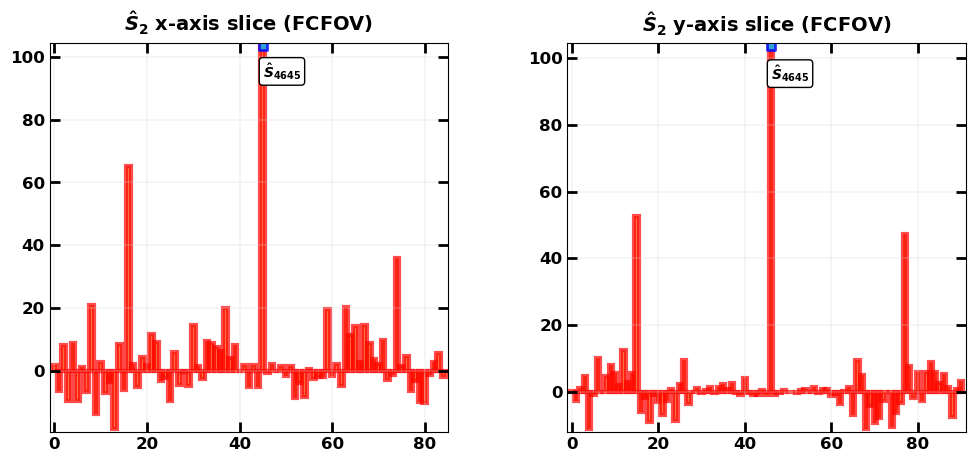

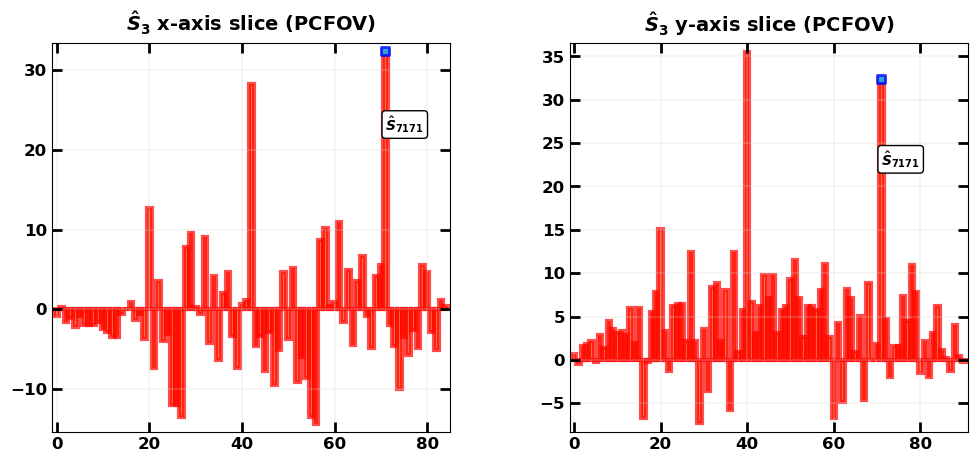

In [28]:
stats.enhance_skyrec_slices(pcfov_sky_reconstruction, sources_pos)

- If now we perform the balancing, we can correct the reconstruction in the PCFOV and also reduce the emerging coding noise in the FCFOV (and in the PCFOV as well)

### **Balancing with formula by Peppe**

- The formula from Peppe for balancing the effect of sources in the PCFOV on the FCFOV is:

$$\hat{S} = G \star D - G \star W \cdot {\sum d_{i} \over \sum w_{i}}$$

- $W$ is the bulk array or sensitive array, an array of weights for the detector response (values between 0 and 1).

pcfov_sky_reconstruction = bal_sky_reconstruction_peppe shape: True

S_hat[0] - S[0]: -81.77777777777779
Bal_S_hat[0] - S[0]: -80.12853788159684

S_hat[1] - S[1]: 0.44444444444441444
Bal_S_hat[1] - S[1]: 0.1695711284142618

S_hat[2] - S[2]: 3.5555555555555003
Bal_S_hat[2] - S[2]: 3.2806822395253477

S_hat[3] - S[3]: -67.55555555555557
Bal_S_hat[3] - S[3]: -69.20479545173652



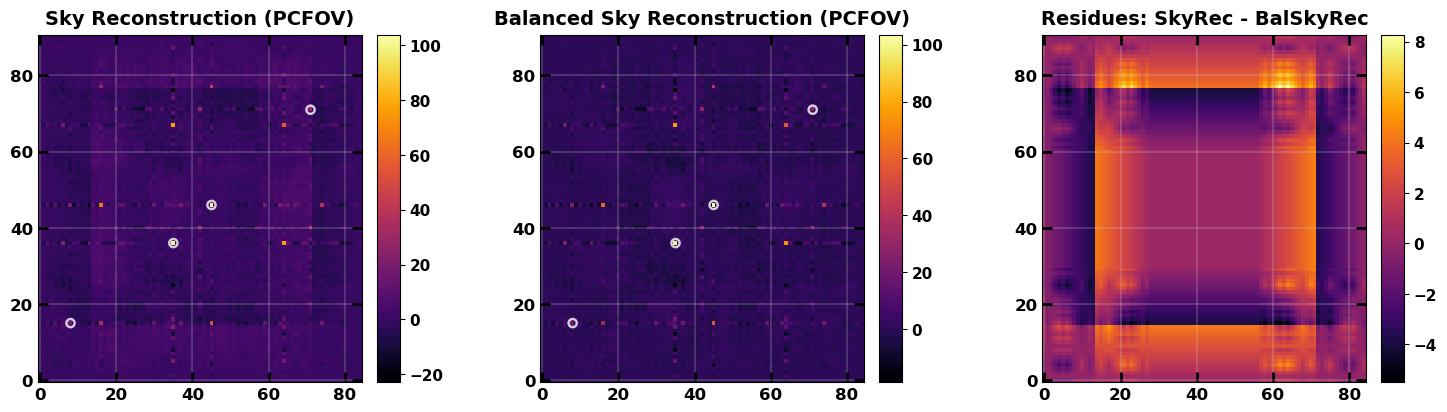

In [45]:
bulk_array = np.ones(fcfov_detector_image.shape)

bal_peppe = bal.BalancedSkyReconstruction_Peppe(decoder, bulk_array)
bal_sky_reconstruction_peppe = bal_peppe.balanced_sky_reconstruction(fcfov_detector_image)

print(f"pcfov_sky_reconstruction = bal_sky_reconstruction_peppe shape: {np.all(pcfov_sky_reconstruction.shape == bal_sky_reconstruction_peppe.shape)}\n")

for idx, pos in enumerate(sources_pos):
    print(f"S_hat[{idx}] - S[{idx}]: {pcfov_sky_reconstruction[*pos] - sky_image[*pos]}\n"
          f"Bal_S_hat[{idx}] - S[{idx}]: {bal_sky_reconstruction_peppe[*pos] - sky_image[*pos]}\n")

plot.image_plot([pcfov_sky_reconstruction, bal_sky_reconstruction_peppe, pcfov_sky_reconstruction - bal_sky_reconstruction_peppe],
                ["Sky Reconstruction (PCFOV)", "Balanced Sky Reconstruction (PCFOV)", "Residues: SkyRec - BalSkyRec"],
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, sources_pos, None])

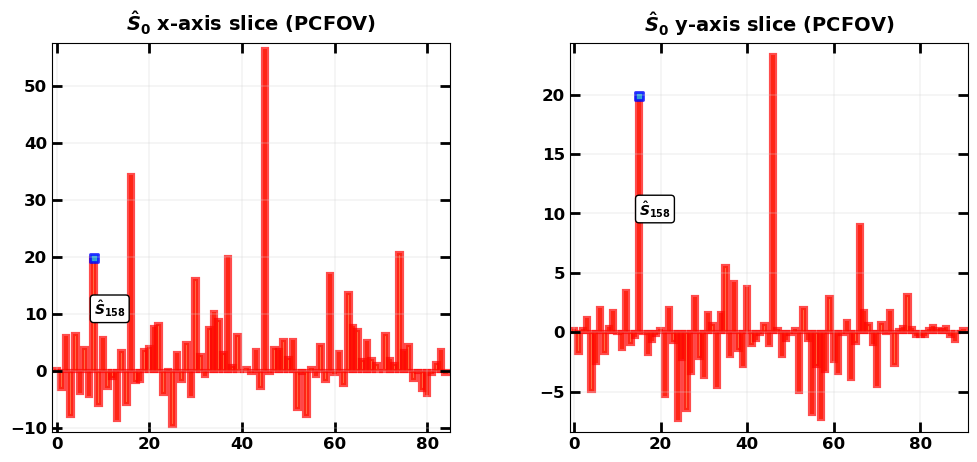

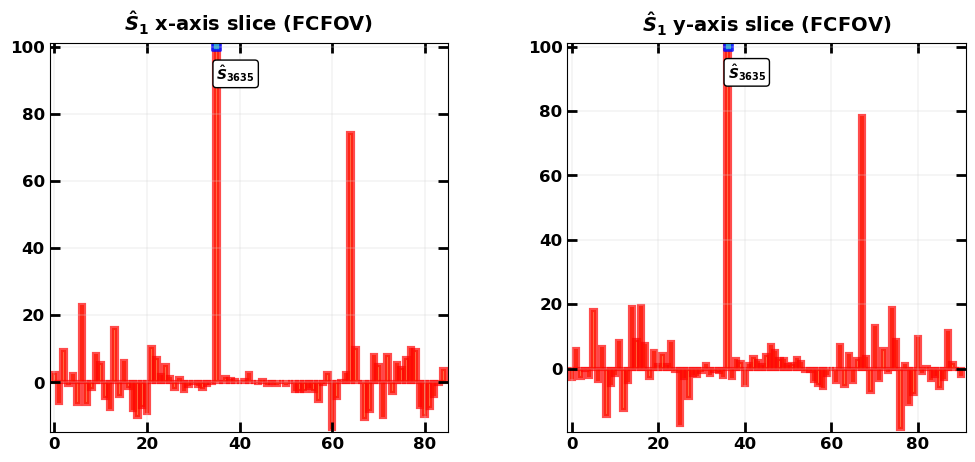

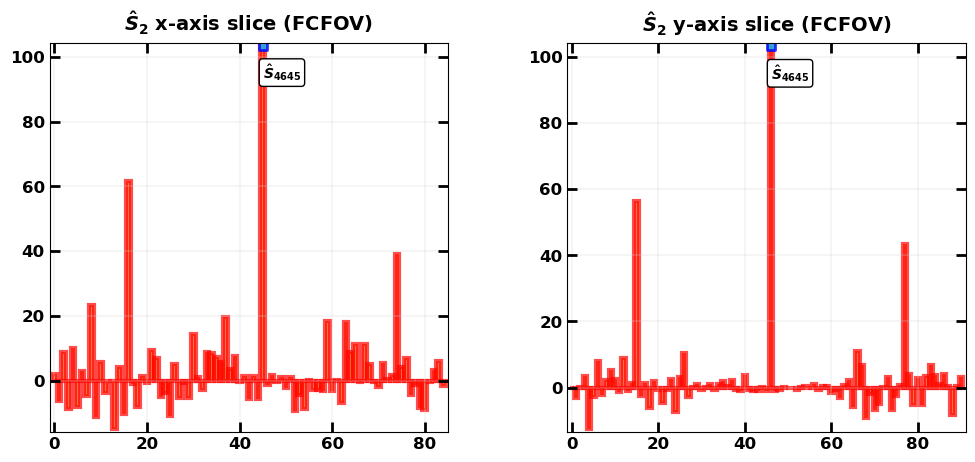

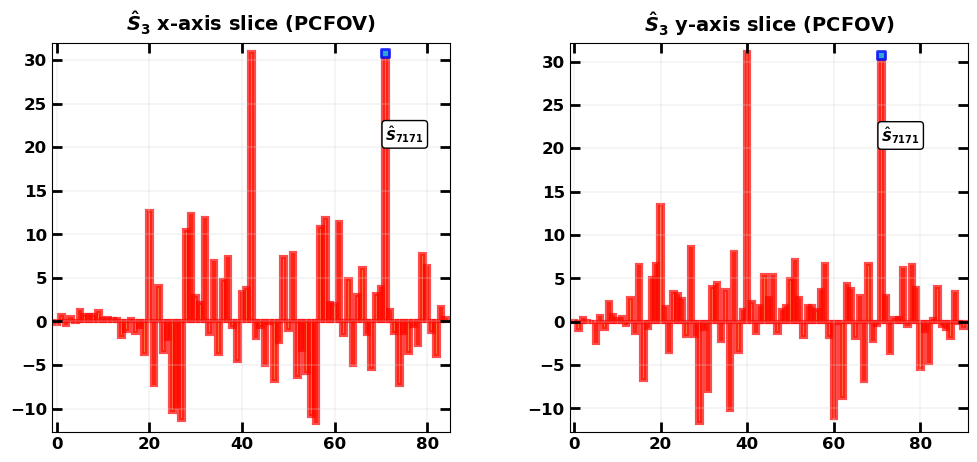

In [30]:
stats.enhance_skyrec_slices(bal_sky_reconstruction_peppe, sources_pos)

### **Balancing with formula by Goldwurm**

- The formula from Goldwurm for balancing the effect of sources in the PCFOV on the FCFOV can be found in:

    **[1]** A. Goldwurm and A. Gros, "Coded Mask Instruments for Gamma-Ray Astronomy", 2023 (in "Handbook of X-ray and Gamma-ray Astrophysics", Springer 2023)

<br>

- In this formalism, the decoder is splitted in the $G^{+}$ and $G^{-}$ terms so that $G = G^{+} + G^{-}$, and the reconstructed sky is obtained consider again a bulk array $W$ and a balancing array $B$ that weights the contributes from the decoding pattern:

$$\hat{S} = {G^{+} \star (D\cdot W) - B \cdot [G^{-} \star (D\cdot W)] \over N}$$

- where:

    - $W$ is the bulk array or sensitive array, an array of weights for the detector response (values between 0 and 1)
    - $B$ is the balancing array $$B = {G^{+} \star W \over G^{-} \star W}$$
    - $N$ is a normalization array $$N = {(G^{+}\cdot A) \star W - B \cdot [(G^{-}\cdot A) \star W}]$$

<br>

- The balance array $B$ is used to account for the different open to closed mask element ratio and ensures a flat image with zero mean in absence of sources

- The normalization array allows a correct source flux reconstruction which takes into account the partial modulation. With this normalization the sky reconstruction gives at the source peak the mean recorded source counts within one totally illuminated detector pixel.

pcfov_sky_reconstruction = bal_sky_reconstruction_goldwurm shape: True

S_hat[0] - S[0]: -1635.5555555555557
Bal_S_hat[0] - S[0]: 525.2173913043434

S_hat[1] - S[1]: 8.888888888888005
Bal_S_hat[1] - S[1]: 5.6223707003211985

S_hat[2] - S[2]: 71.1111111111095
Bal_S_hat[2] - S[2]: 67.91388270230073

S_hat[3] - S[3]: -1351.1111111111113
Bal_S_hat[3] - S[3]: -44.40814659792932



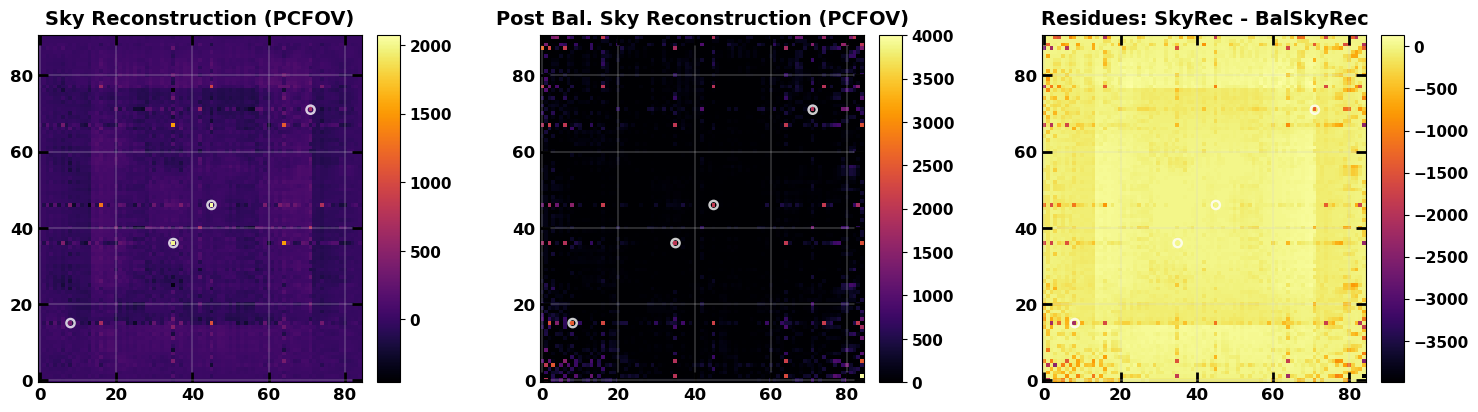

In [57]:
bal_goldwurm = bal.BalancedSkyReconstruction_Goldwurm(mask, decoder, bulk_array)
bal_sky_reconstruction_goldwurm, _ = bal_goldwurm.balanced_sky_reconstruction(fcfov_detector_image, False)

post_bal_sky_reconstruction_goldwurm = bal_sky_reconstruction_goldwurm.copy()
post_bal_sky_reconstruction_goldwurm[bal_sky_reconstruction_goldwurm > 4500] = 0     # remove artifacts
post_bal_sky_reconstruction_goldwurm[bal_sky_reconstruction_goldwurm < 0] = 0       # remove negative counts


print(f"pcfov_sky_reconstruction = bal_sky_reconstruction_goldwurm shape: {np.all(pcfov_sky_reconstruction.shape == bal_sky_reconstruction_goldwurm.shape)}\n")

for idx, pos in enumerate(sources_pos):
    print(f"S_hat[{idx}] - S[{idx}]: {pcfov_sky_reconstruction[*pos] - sky_image[*pos]}\n"
          f"Bal_S_hat[{idx}] - S[{idx}]: {bal_sky_reconstruction_goldwurm[*pos] - sky_image[*pos]}\n")

plot.image_plot([pcfov_sky_reconstruction, post_bal_sky_reconstruction_goldwurm, pcfov_sky_reconstruction - post_bal_sky_reconstruction_goldwurm],
                ["Sky Reconstruction (PCFOV)", "Post Bal. Sky Reconstruction (PCFOV)", "Residues: SkyRec - BalSkyRec"],
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, sources_pos, sources_pos])

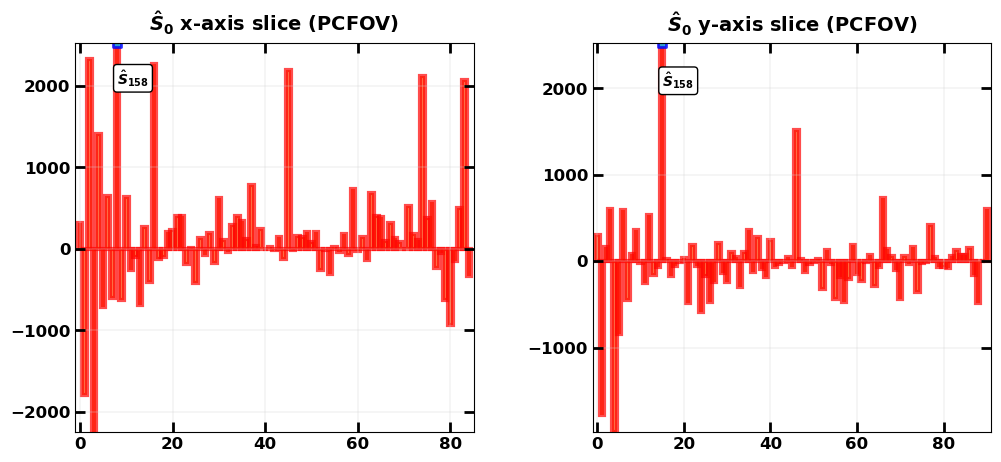

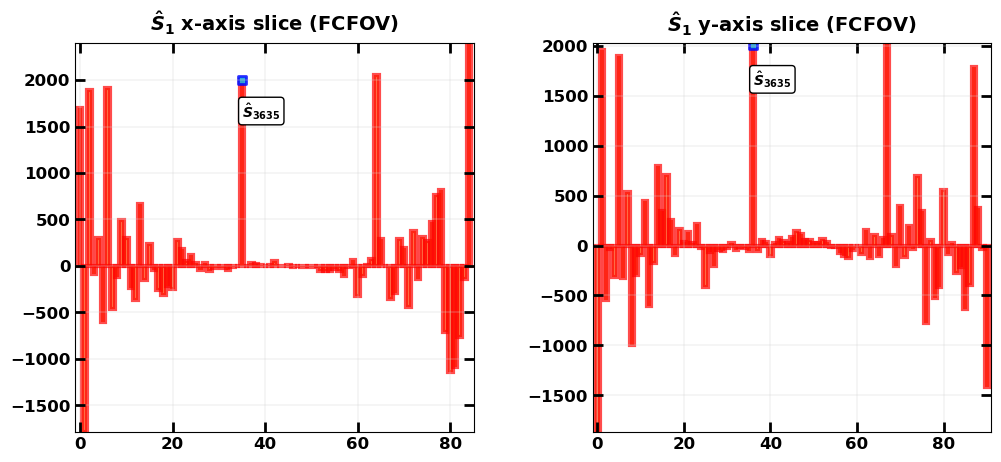

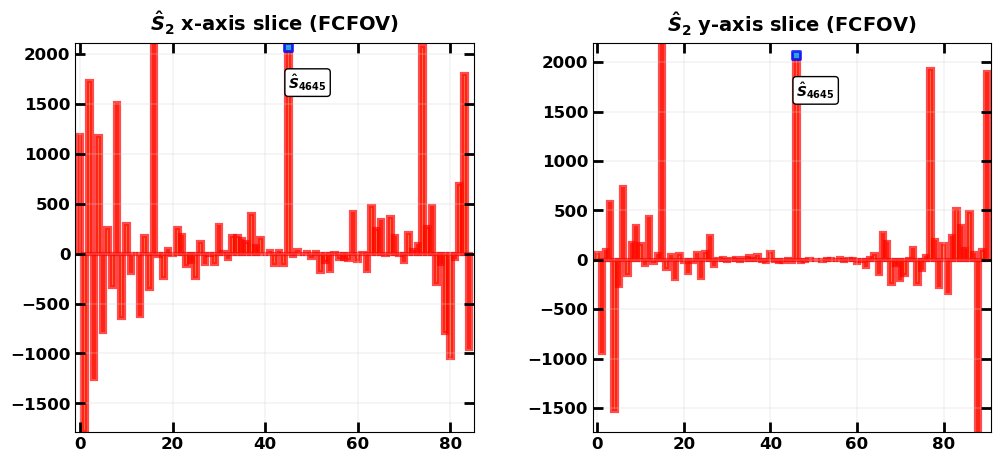

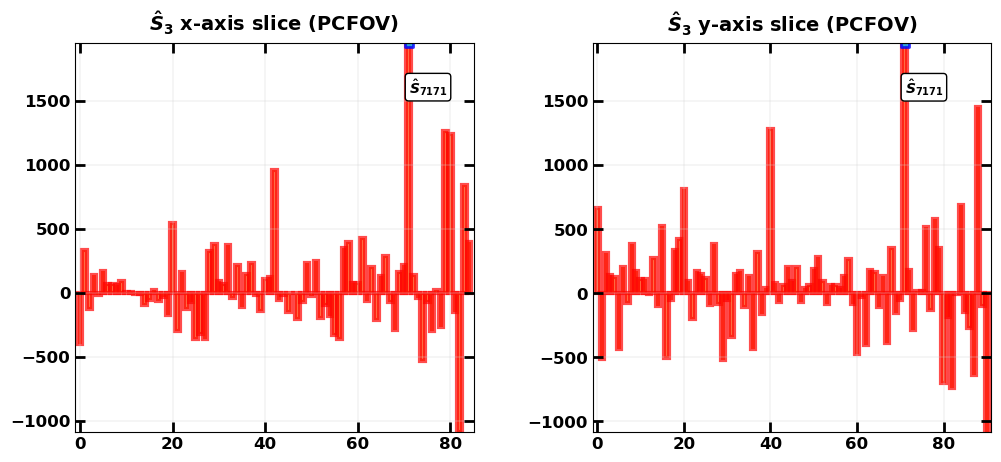

In [65]:
stats.enhance_skyrec_slices(bal_sky_reconstruction_goldwurm, sources_pos)

## **2D URA/MURA Masks with PCFOV - FCFOV Sources**

- Analyzing the reconstruction per se, if we have sources only in the FCFOV, we expect the coding noise to emerge only in the PCFOV

- Moreover, the FCFOV should be flat if there is not sky background

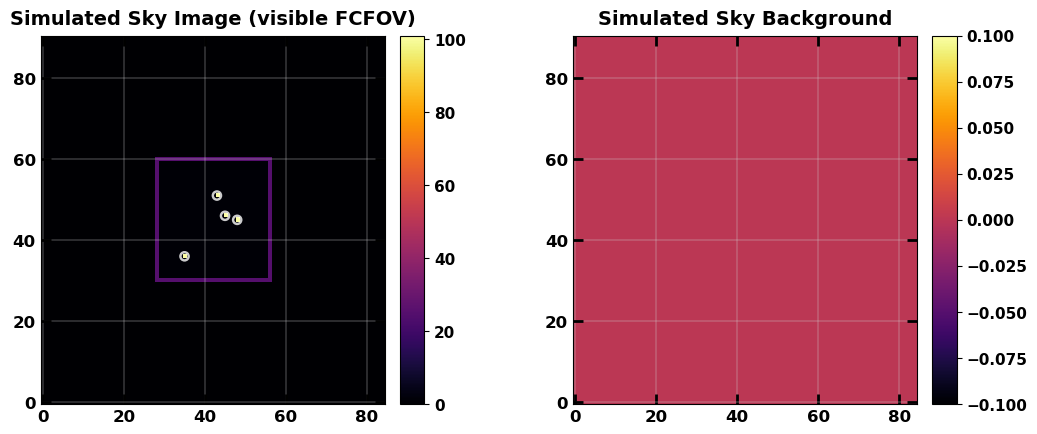

In [23]:
sources_flux = np.array([100, 100, 100, 100])
sources_pos = [(h + 15, v + 20), (n + 5, m + 6), (n + 15, m + 16), (h + n - 10, v + m - 14)]

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

highlight_fcfov = True
if highlight_fcfov:
    base = np.ones((n - 2, m - 2))
    c_edge = np.pad(base, pad_width=[(1, 1), (1, 1)], constant_values=sources_flux.max()//4)

    sky_image_wfcfov = sky_image.copy()
    sky_image_wfcfov[h : -h, v : -v] += c_edge

    plot.image_plot([sky_image_wfcfov, sky_background],
                    ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

cc_detector_image = sky image shape: True
pcfov_sky_reconstruction = sky image shape: True
fcfov_sky_reconstruction = basic pattern shape: True


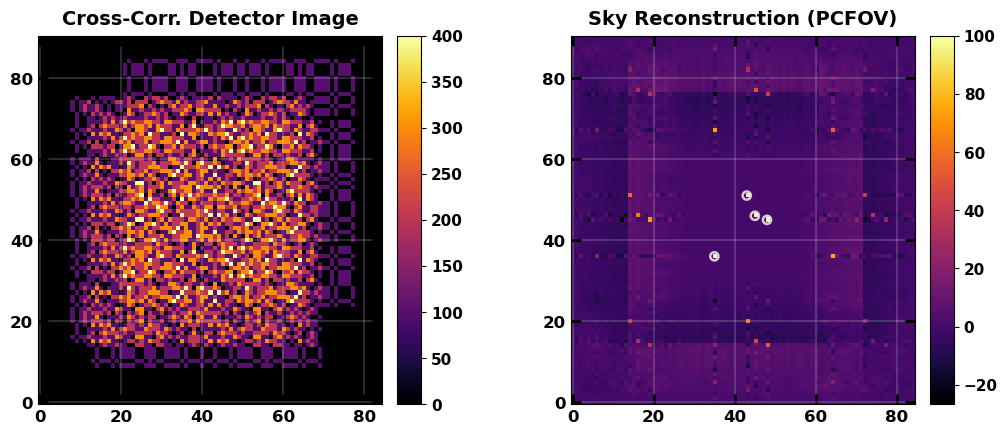

In [24]:
cc_detector_image = correlate(mask, sky_image, mode='full')[h : -h, v : -v]
fcfov_detector_image = cc_detector_image[h : -h, v : -v]                            ### detector area corresponding to FCFOV

pcfov_sky_reconstruction = correlate(decoder, fcfov_detector_image, mode='full')    ### here the FCFOV portion of the central detector image
fcfov_sky_reconstruction = pcfov_sky_reconstruction[h : -h, v : -v]

print(f"cc_detector_image = sky image shape: {np.all(cc_detector_image.shape == sky_shape)}\n"
      f"pcfov_sky_reconstruction = sky image shape: {np.all(pcfov_sky_reconstruction.shape == sky_shape)}\n"
      f"fcfov_sky_reconstruction = basic pattern shape: {np.all(fcfov_sky_reconstruction.shape == (n, m))}")

plot.image_plot([cc_detector_image, pcfov_sky_reconstruction],
                ["Cross-Corr. Detector Image", "Sky Reconstruction (PCFOV)"],
                cbarcmap=["inferno"]*2,
                simulated_sources=[None, sources_pos])

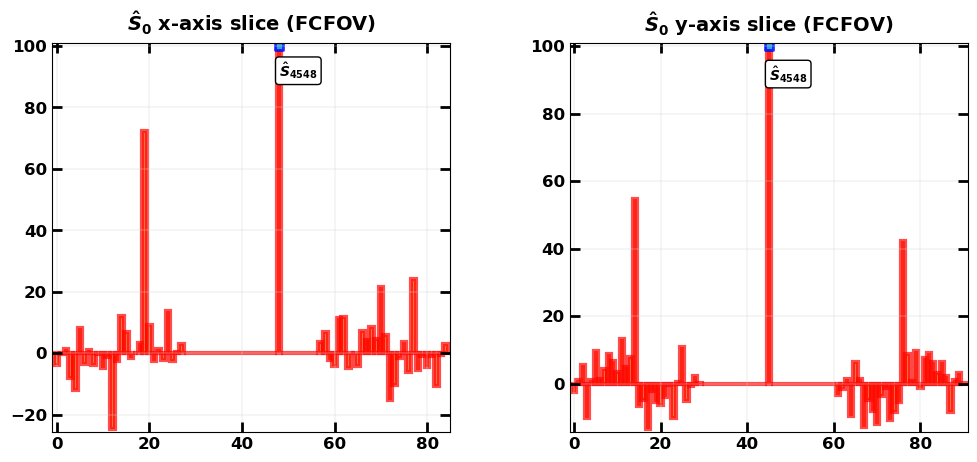

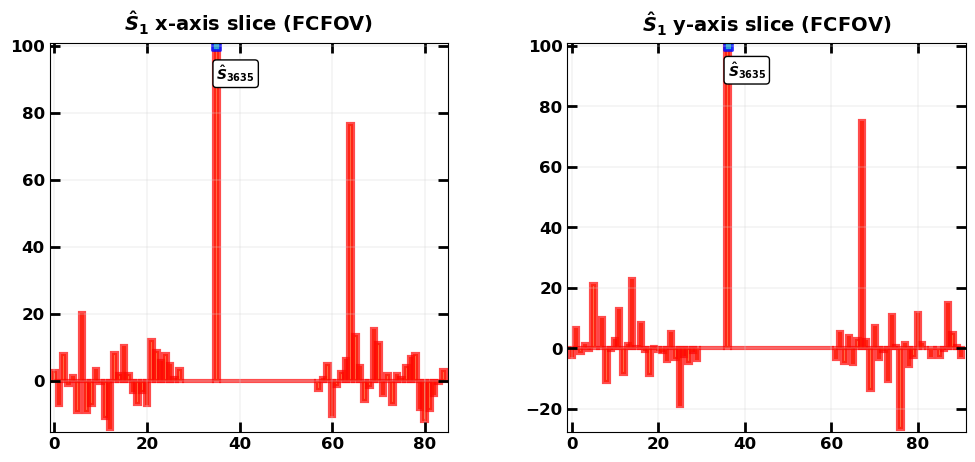

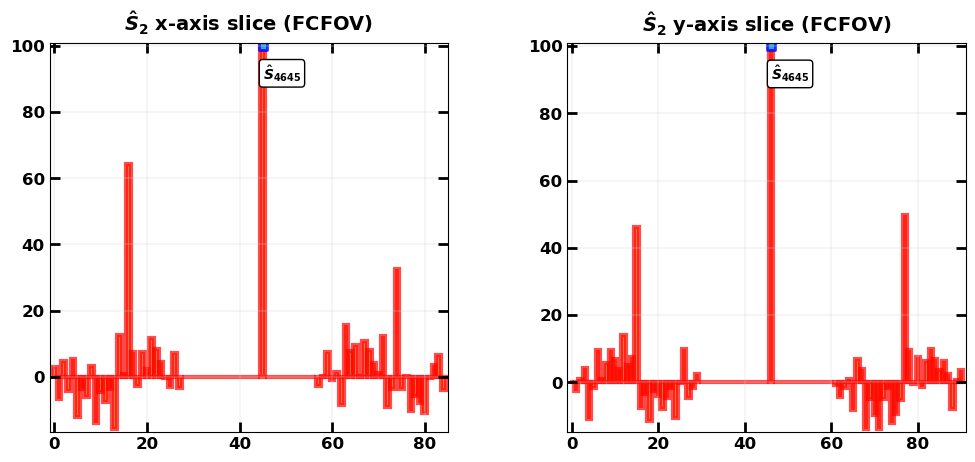

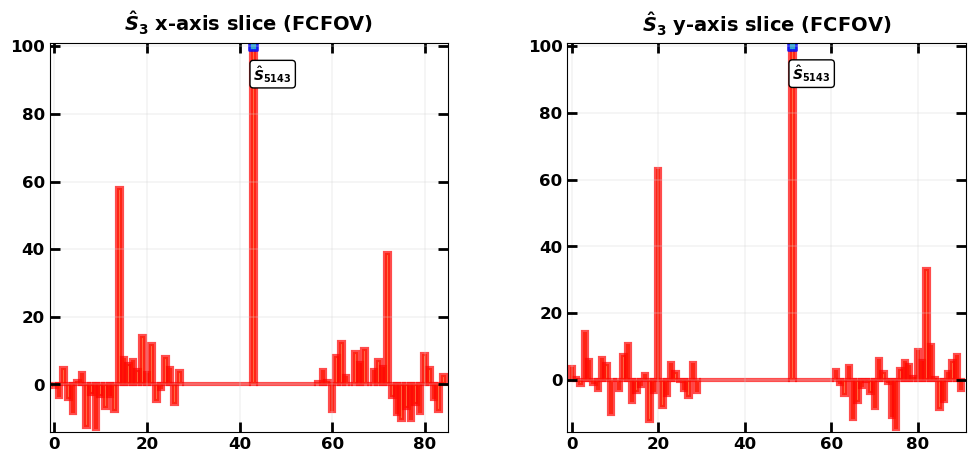

In [25]:
stats.enhance_skyrec_slices(pcfov_sky_reconstruction, sources_pos)